In [6]:
pip install pandas_market_calendars

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.4/127.4 kB 2.6 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.8/347.8 kB 8.6 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.6/203.6 kB 21.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


[*********************100%***********************]  1 of 1 completed


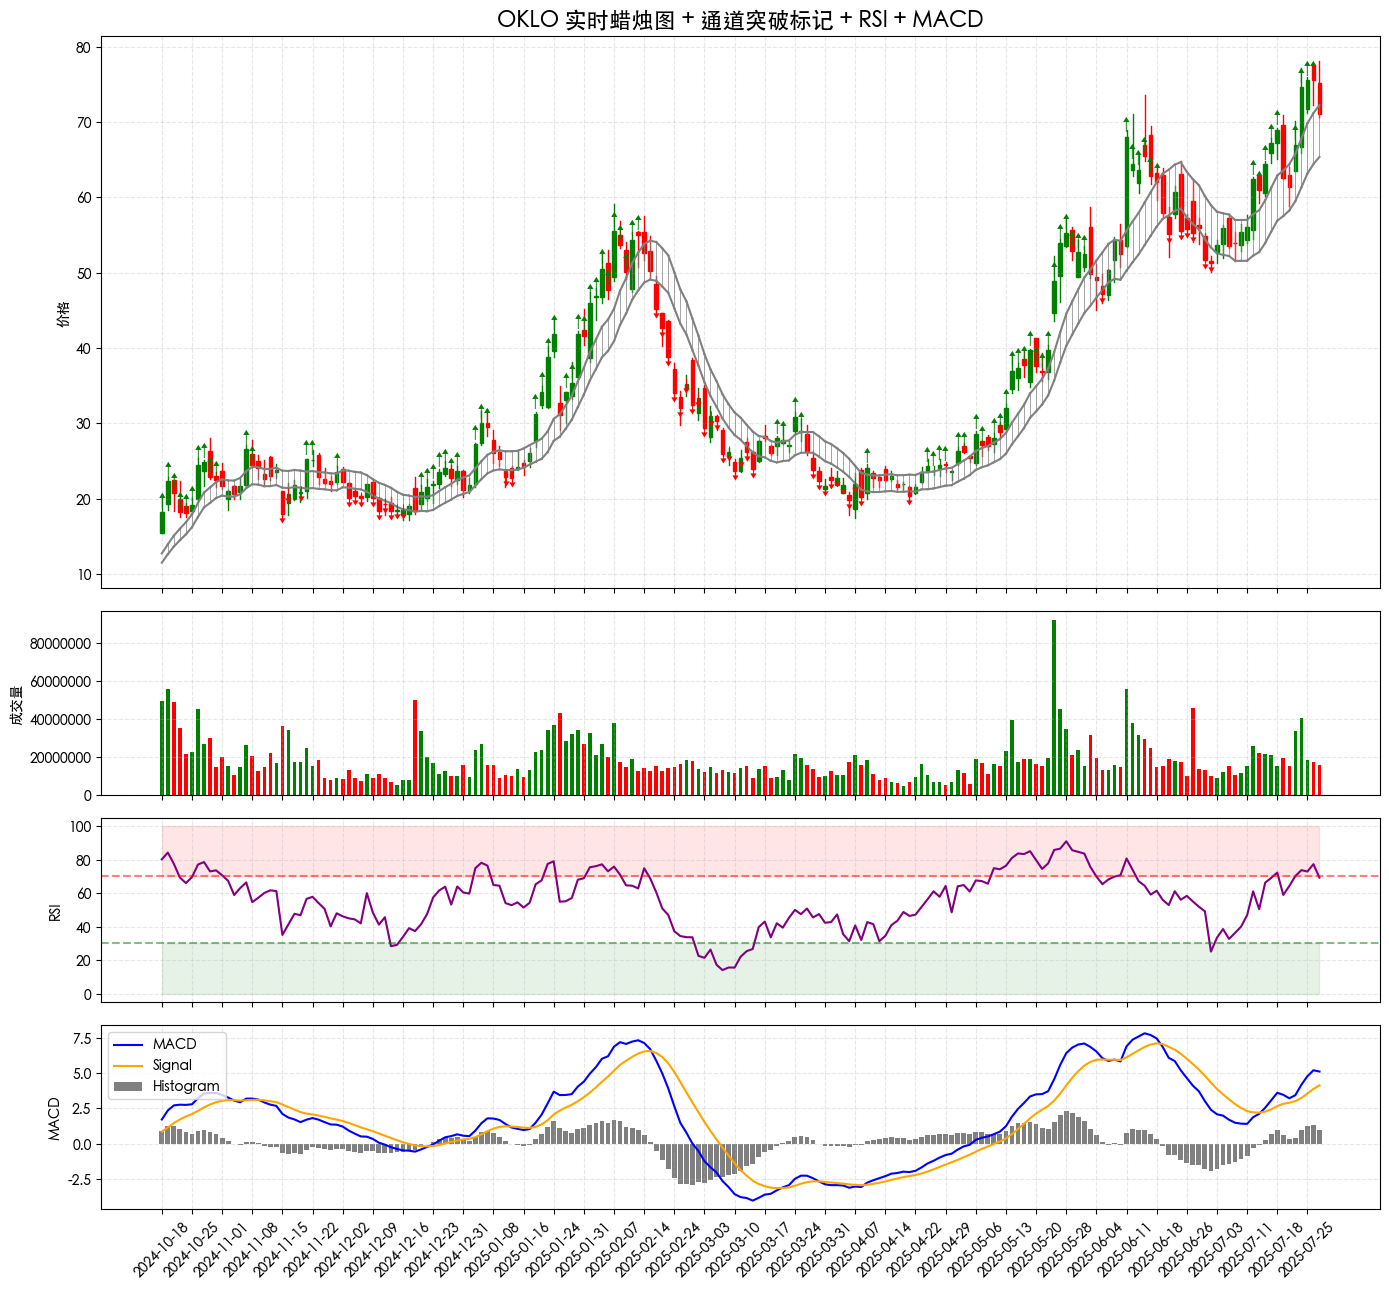

In [32]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Rectangle
import pandas_market_calendars as mcal
import matplotlib.font_manager as fm
import platform

# ========== 字体设置 ==========
system = platform.system()
if system == 'Darwin':
    font_candidate = ['PingFang SC', 'Heiti TC', 'Arial Unicode MS']
elif system == 'Windows':
    font_candidate = ['Microsoft YaHei', 'SimHei']
else:
    font_candidate = ['Noto Sans CJK SC', 'WenQuanYi Zen Hei']

available_fonts = set(f.name for f in fm.fontManager.ttflist)
for font in font_candidate:
    if font in available_fonts:
        plt.rcParams['font.family'] = font
        break
plt.rcParams['axes.unicode_minus'] = False

# ========== 获取 OKLO 股票数据 ==========
df = yf.download("OKLO", start="2024-10-01", end="2025-07-30", auto_adjust=False)
if df.empty:
    print("❌ 数据为空")
    exit()

# 过滤非交易日
nyse = mcal.get_calendar('NYSE')
schedule = nyse.schedule(start_date='2024-10-01', end_date='2025-07-30')
trading_days = schedule.index.tz_localize(None)
df = df[df.index.isin(trading_days)]

# ========== 技术指标计算 ==========
df['MA10'] = df['Close'].rolling(window=10).mean()
df['Upper'] = df['MA10'] * 1.05
df['Lower'] = df['MA10'] * 0.95

# RSI
delta = df['Close'].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()
rs = avg_gain / avg_loss
df['RSI'] = 100 - (100 / (1 + rs))

# MACD
ema12 = df['Close'].ewm(span=12, adjust=False).mean()
ema26 = df['Close'].ewm(span=26, adjust=False).mean()
df['MACD'] = ema12 - ema26
df['Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
df['Hist'] = df['MACD'] - df['Signal']

df = df.dropna()
df['Index'] = range(len(df))

# ========== 创建子图结构 ==========
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(14, 13), sharex=True,
                                         gridspec_kw={'height_ratios': [3, 1, 1, 1]})
ax1.set_title("OKLO 实时蜡烛图 + 通道突破标记 + RSI + MACD", fontsize=16)

# ========== K线图绘制 + 成交量 ==========
for i in range(len(df)):
    x = df['Index'].iloc[i]
    o, c = float(df['Open'].iloc[i]), float(df['Close'].iloc[i])
    h, l = float(df['High'].iloc[i]), float(df['Low'].iloc[i])
    v = float(df['Volume'].iloc[i])
    color = 'green' if c >= o else 'red'
    rect = Rectangle((x - 0.3, min(o, c)), 0.6, abs(c - o), color=color)
    ax1.add_patch(rect)
    ax1.plot([x, x], [l, h], color=color, linewidth=1)
    ax2.bar(x, v, color=color, width=0.6)

# ========== 梯子通道绘制 ==========
for i in range(1, len(df)):
    x0, x1 = df['Index'].iloc[i - 1], df['Index'].iloc[i]
    ax1.plot([x0, x1], [df['Upper'].iloc[i - 1], df['Upper'].iloc[i]], color='gray')
    ax1.plot([x0, x1], [df['Lower'].iloc[i - 1], df['Lower'].iloc[i]], color='gray')
    ax1.plot([x1, x1], [df['Lower'].iloc[i], df['Upper'].iloc[i]], color='gray', linewidth=0.5)

# ========== 通道突破箭头 ==========
for i in range(len(df)):
    x = df['Index'].iloc[i]
    price = float(df['Close'].iloc[i])
    up = float(df['Upper'].iloc[i])
    low = float(df['Lower'].iloc[i])

    if price > up:
        ax1.annotate('↑', (x, price + 1), color='green', fontsize=12, ha='center')
    elif price < low:
        ax1.annotate('↓', (x, price - 1), color='red', fontsize=12, ha='center')

# ========== RSI 绘图 + 超买超卖区域高亮 ==========
ax3.plot(df['Index'], df['RSI'], color='purple', label='RSI')
ax3.axhline(70, color='red', linestyle='--', alpha=0.5)
ax3.axhline(30, color='green', linestyle='--', alpha=0.5)
ax3.fill_between(df['Index'], 70, 100, color='red', alpha=0.1)
ax3.fill_between(df['Index'], 0, 30, color='green', alpha=0.1)
ax3.set_ylabel("RSI")

# ========== MACD 绘图 ==========
ax4.bar(df['Index'], df['Hist'], color='gray', label='Histogram')
ax4.plot(df['Index'], df['MACD'], color='blue', label='MACD')
ax4.plot(df['Index'], df['Signal'], color='orange', label='Signal')
ax4.legend(loc='upper left')
ax4.set_ylabel("MACD")

# ========== x 轴设置 ==========
ax4.set_xticks(df['Index'][::5])
ax4.set_xticklabels(df.index.strftime('%Y-%m-%d')[::5], rotation=45)

# ========== y轴样式 ==========
for ax in [ax1, ax2, ax3, ax4]:
    ax.tick_params(axis='y', labelsize=10)
    ax.ticklabel_format(style='plain', axis='y')
    ax.grid(True, linestyle='--', alpha=0.3)

ax1.set_ylabel("价格")
ax2.set_ylabel("成交量")

plt.tight_layout()
plt.show()

[*********************100%***********************]  1 of 1 completed


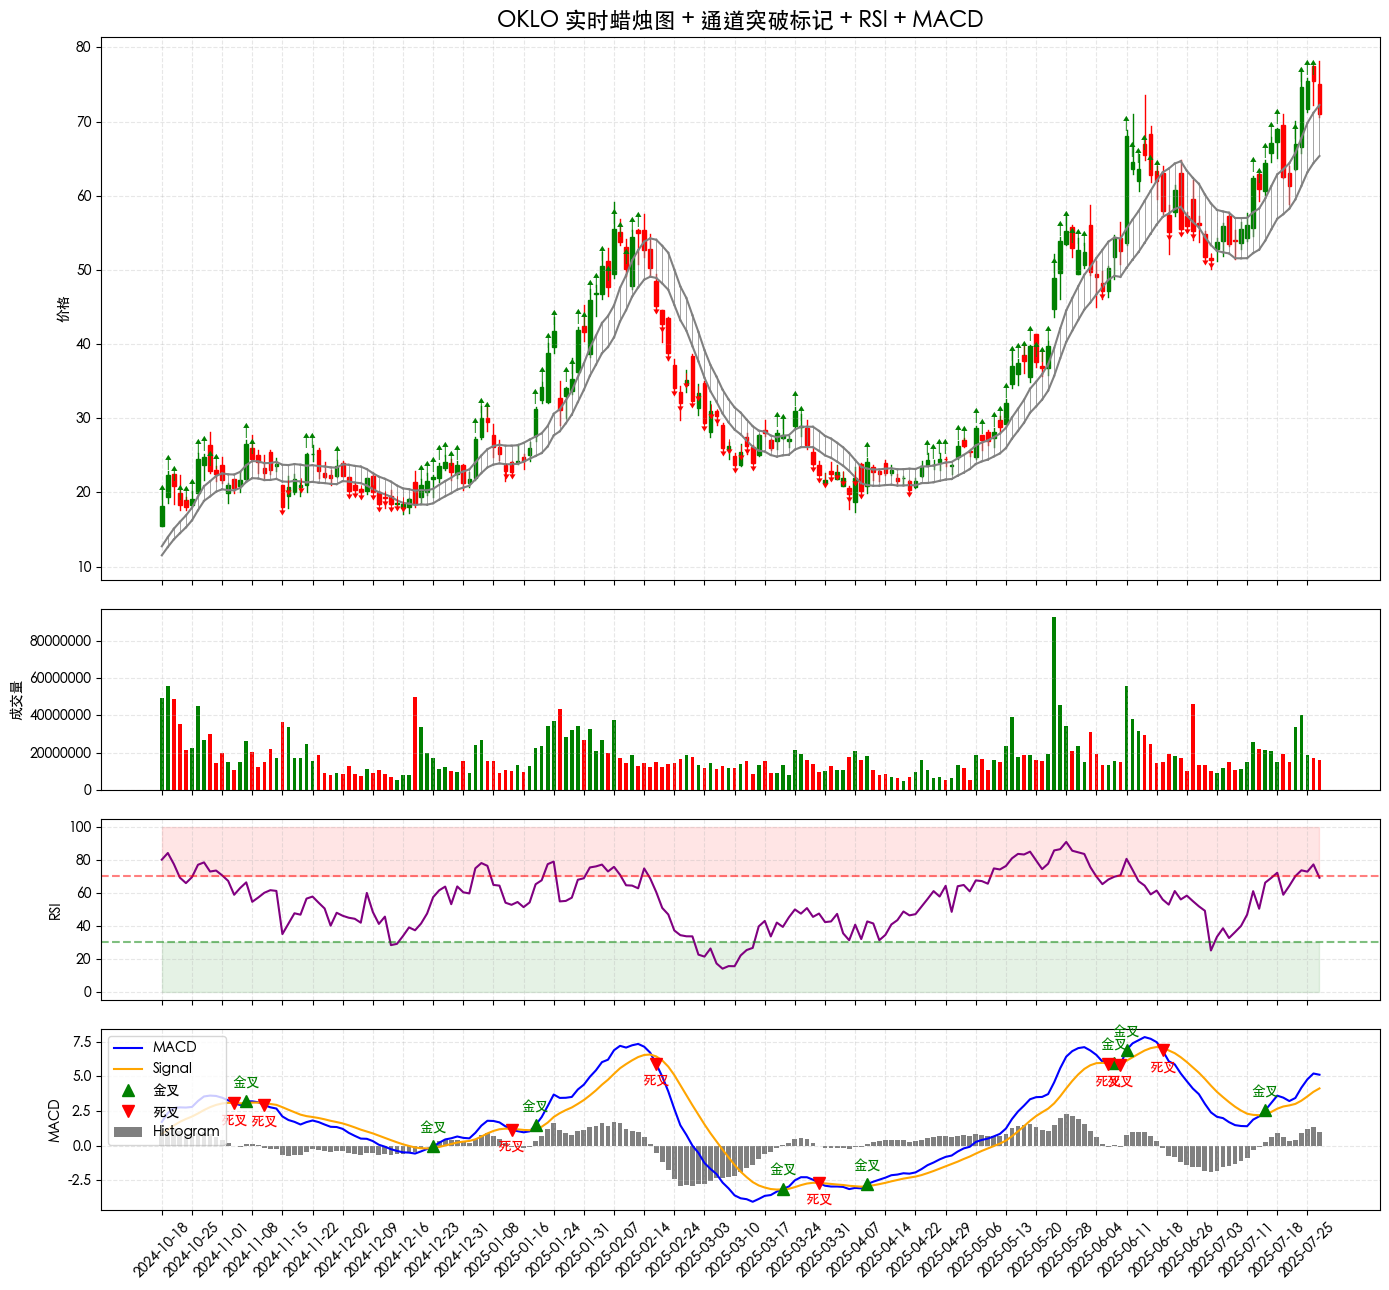

In [35]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Rectangle
import pandas_market_calendars as mcal
import matplotlib.font_manager as fm
import platform

# ========== 字体设置 ==========
system = platform.system()
if system == 'Darwin':
    font_candidate = ['PingFang SC', 'Heiti TC', 'Arial Unicode MS']
elif system == 'Windows':
    font_candidate = ['Microsoft YaHei', 'SimHei']
else:
    font_candidate = ['Noto Sans CJK SC', 'WenQuanYi Zen Hei']

available_fonts = set(f.name for f in fm.fontManager.ttflist)
for font in font_candidate:
    if font in available_fonts:
        plt.rcParams['font.family'] = font
        break
plt.rcParams['axes.unicode_minus'] = False

# ========== 获取 OKLO 股票数据 ==========
df = yf.download("OKLO", start="2024-10-01", end="2025-07-30", auto_adjust=False)
if df.empty:
    print("❌ 数据为空")
    exit()

# 过滤非交易日
nyse = mcal.get_calendar('NYSE')
schedule = nyse.schedule(start_date='2024-10-01', end_date='2025-07-30')
trading_days = schedule.index.tz_localize(None)
df = df[df.index.isin(trading_days)]

# ========== 技术指标计算 ==========
df['MA10'] = df['Close'].rolling(window=10).mean()
df['Upper'] = df['MA10'] * 1.05
df['Lower'] = df['MA10'] * 0.95

# RSI
delta = df['Close'].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()
rs = avg_gain / avg_loss
df['RSI'] = 100 - (100 / (1 + rs))

# MACD
ema12 = df['Close'].ewm(span=12, adjust=False).mean()
ema26 = df['Close'].ewm(span=26, adjust=False).mean()
df['MACD'] = ema12 - ema26
df['Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
df['Hist'] = df['MACD'] - df['Signal']

# Calculate MACD crossovers
df['MACD_Cross_Up'] = (df['MACD'] > df['Signal']) & (df['MACD'].shift(1) <= df['Signal'].shift(1))
df['MACD_Cross_Down'] = (df['MACD'] < df['Signal']) & (df['MACD'].shift(1) >= df['Signal'].shift(1))

df = df.dropna()
df['Index'] = range(len(df))

# ========== 创建子图结构 ==========
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(14, 13), sharex=True,
                                         gridspec_kw={'height_ratios': [3, 1, 1, 1]})
ax1.set_title("OKLO 实时蜡烛图 + 通道突破标记 + RSI + MACD", fontsize=16)

# ========== K线图绘制 + 成交量 ==========
for i in range(len(df)):
    x = df['Index'].iloc[i]
    o, c = float(df['Open'].iloc[i]), float(df['Close'].iloc[i])
    h, l = float(df['High'].iloc[i]), float(df['Low'].iloc[i])
    v = float(df['Volume'].iloc[i])
    color = 'green' if c >= o else 'red'
    rect = Rectangle((x - 0.3, min(o, c)), 0.6, abs(c - o), color=color)
    ax1.add_patch(rect)
    ax1.plot([x, x], [l, h], color=color, linewidth=1)
    ax2.bar(x, v, color=color, width=0.6)

# ========== 梯子通道绘制 ==========
for i in range(1, len(df)):
    x0, x1 = df['Index'].iloc[i - 1], df['Index'].iloc[i]
    ax1.plot([x0, x1], [df['Upper'].iloc[i - 1], df['Upper'].iloc[i]], color='gray')
    ax1.plot([x0, x1], [df['Lower'].iloc[i - 1], df['Lower'].iloc[i]], color='gray')
    ax1.plot([x1, x1], [df['Lower'].iloc[i], df['Upper'].iloc[i]], color='gray', linewidth=0.5)

# ========== 通道突破箭头 ==========
for i in range(len(df)):
    x = df['Index'].iloc[i]
    price = float(df['Close'].iloc[i])
    up = float(df['Upper'].iloc[i])
    low = float(df['Lower'].iloc[i])

    if price > up:
        ax1.annotate('↑', (x, price + 1), color='green', fontsize=12, ha='center')
    elif price < low:
        ax1.annotate('↓', (x, price - 1), color='red', fontsize=12, ha='center')

# ========== RSI 绘图 + 超买超卖区域高亮 ==========
ax3.plot(df['Index'], df['RSI'], color='purple', label='RSI')
ax3.axhline(70, color='red', linestyle='--', alpha=0.5)
ax3.axhline(30, color='green', linestyle='--', alpha=0.5)
ax3.fill_between(df['Index'], 70, 100, color='red', alpha=0.1)
ax3.fill_between(df['Index'], 0, 30, color='green', alpha=0.1)
ax3.set_ylabel("RSI")

# ========== MACD 绘图 ==========
ax4.bar(df['Index'], df['Hist'], color='gray', label='Histogram')
ax4.plot(df['Index'], df['MACD'], color='blue', label='MACD')
ax4.plot(df['Index'], df['Signal'], color='orange', label='Signal')

# Mark MACD Golden Cross (金叉)
golden_cross_indices = df[df['MACD_Cross_Up']].index
for idx in golden_cross_indices:
    x_pos = df.loc[idx, 'Index']
    y_pos = df.loc[idx, 'MACD']  # Or Signal, as they are crossing
    ax4.plot(x_pos, y_pos, '^', markersize=8, color='green', label='金叉' if idx == golden_cross_indices[0] else "") # Only label once
    ax4.annotate('金叉', (x_pos, y_pos), textcoords="offset points", xytext=(0,10), ha='center', color='green', fontsize=10)

# Mark MACD Death Cross (死叉)
death_cross_indices = df[df['MACD_Cross_Down']].index
for idx in death_cross_indices:
    x_pos = df.loc[idx, 'Index']
    y_pos = df.loc[idx, 'MACD'] # Or Signal, as they are crossing
    ax4.plot(x_pos, y_pos, 'v', markersize=8, color='red', label='死叉' if idx == death_cross_indices[0] else "") # Only label once
    ax4.annotate('死叉', (x_pos, y_pos), textcoords="offset points", xytext=(0,-15), ha='center', color='red', fontsize=10)

ax4.legend(loc='upper left')
ax4.set_ylabel("MACD")

# ========== x 轴设置 ==========
ax4.set_xticks(df['Index'][::5])
ax4.set_xticklabels(df.index.strftime('%Y-%m-%d')[::5], rotation=45)

# ========== y轴样式 ==========
for ax in [ax1, ax2, ax3, ax4]:
    ax.tick_params(axis='y', labelsize=10)
    ax.ticklabel_format(style='plain', axis='y')
    ax.grid(True, linestyle='--', alpha=0.3)

ax1.set_ylabel("价格")
ax2.set_ylabel("成交量")

plt.tight_layout()
plt.show()

In [2]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import pandas_market_calendars as mcal
import matplotlib.font_manager as fm
import platform
import numpy as np

def plot_stock_chart(ticker="OKLO", start="2024-01-01", end="2025-07-30"):
    # ===== 字体设置 =====
    system = platform.system()
    font_candidate = ['Microsoft YaHei', 'PingFang SC', 'Heiti TC', 'Arial Unicode MS', 'SimHei', 'Noto Sans CJK SC']
    available_fonts = set(f.name for f in fm.fontManager.ttflist)
    for font in font_candidate:
        if font in available_fonts:
            plt.rcParams['font.family'] = font
            break
    plt.rcParams['axes.unicode_minus'] = False

    # ===== 下载数据 =====
    df = yf.download(ticker, start=start, end=end, auto_adjust=False)
    if df.empty:
        print(f"❌ 股票代码 {ticker} 没有获取到数据")
        return

    # 过滤 NYSE 交易日
    nyse = mcal.get_calendar('NYSE')
    schedule = nyse.schedule(start_date=start, end_date=end)
    trading_days = schedule.index.tz_localize(None)
    df = df[df.index.isin(trading_days)].copy()

    # ===== 技术指标 =====
    df['MA10'] = df['Close'].rolling(window=10).mean()
    df['Upper'] = df['MA10'] * 1.05
    df['Lower'] = df['MA10'] * 0.95

    # RSI
    delta = df['Close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=14).mean()
    avg_loss = loss.rolling(window=14).mean()
    rs = avg_gain / avg_loss
    df['RSI'] = 100 - (100 / (1 + rs))

    # MACD
    ema12 = df['Close'].ewm(span=12, adjust=False).mean()
    ema26 = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = ema12 - ema26
    df['Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
    df['Hist'] = df['MACD'] - df['Signal']
    df['MACD_Cross_Up'] = (df['MACD'] > df['Signal']) & (df['MACD'].shift(1) <= df['Signal'].shift(1))
    df['MACD_Cross_Down'] = (df['MACD'] < df['Signal']) & (df['MACD'].shift(1) >= df['Signal'].shift(1))

    df = df.dropna()
    df['Index'] = range(len(df))

    # ===== 图结构 =====
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 14), sharex=True,
                                             gridspec_kw={'height_ratios': [3, 1, 1, 1]})
    ax1.set_title(f"{ticker} 技术分析图", fontsize=16)

    # ===== K线 + 成交量 =====
    for i in range(len(df)):
        x = df['Index'].iloc[i]
        o, c = float(df['Open'].iloc[i]), float(df['Close'].iloc[i])
        h, l = float(df['High'].iloc[i]), float(df['Low'].iloc[i])
        v = float(df['Volume'].iloc[i])
        color = 'green' if c >= o else 'red'
        rect = Rectangle((x - 0.3, min(o, c)), 0.6, abs(c - o), color=color)
        ax1.add_patch(rect)
        ax1.plot([x, x], [l, h], color=color, linewidth=1)
        ax2.bar(x, v, color=color, width=0.6)

    # 梯子通道
    for i in range(1, len(df)):
        x0, x1 = df['Index'].iloc[i - 1], df['Index'].iloc[i]
        ax1.plot([x0, x1], [df['Upper'].iloc[i - 1], df['Upper'].iloc[i]], color='gray')
        ax1.plot([x0, x1], [df['Lower'].iloc[i - 1], df['Lower'].iloc[i]], color='gray')
        ax1.plot([x1, x1], [df['Lower'].iloc[i], df['Upper'].iloc[i]], color='gray', linewidth=0.5)

    # 通道突破箭头
    for i in range(len(df)):
        x = df['Index'].iloc[i]
        price = float(df['Close'].iloc[i])
        up = float(df['Upper'].iloc[i])
        low = float(df['Lower'].iloc[i])
        if price > up:
            ax1.annotate('↑', (x, price + 1), color='green', fontsize=12, ha='center')
        elif price < low:
            ax1.annotate('↓', (x, price - 1), color='red', fontsize=12, ha='center')

    # ===== RSI =====
    ax3.plot(df['Index'], df['RSI'], color='purple')
    ax3.axhline(70, color='red', linestyle='--', alpha=0.5)
    ax3.axhline(30, color='green', linestyle='--', alpha=0.5)
    ax3.fill_between(df['Index'], 70, 100, color='red', alpha=0.1)
    ax3.fill_between(df['Index'], 0, 30, color='green', alpha=0.1)
    ax3.set_ylabel("RSI")

    # ===== MACD =====
    ax4.bar(df['Index'], df['Hist'], color='gray', label='Hist')
    ax4.plot(df['Index'], df['MACD'], color='blue', label='MACD')
    ax4.plot(df['Index'], df['Signal'], color='orange', label='Signal')

    # 金叉 / 死叉 标注
    for idx in df[df['MACD_Cross_Up']].index:
        x_pos = df.loc[idx, 'Index']
        y_pos = df.loc[idx, 'MACD']
        ax4.plot(x_pos, y_pos, '^', color='green', markersize=8)
        ax4.annotate('金叉', (x_pos, y_pos), textcoords="offset points", xytext=(0,10), ha='center', color='green', fontsize=10)

    for idx in df[df['MACD_Cross_Down']].index:
        x_pos = df.loc[idx, 'Index']
        y_pos = df.loc[idx, 'MACD']
        ax4.plot(x_pos, y_pos, 'v', color='red', markersize=8)
        ax4.annotate('死叉', (x_pos, y_pos), textcoords="offset points", xytext=(0,-15), ha='center', color='red', fontsize=10)

    ax4.legend(loc='upper left')
    ax4.set_ylabel("MACD")

    # ===== x轴 =====
    ax4.set_xticks(df['Index'][::max(1, len(df)//10)])
    ax4.set_xticklabels(df.index.strftime('%Y-%m-%d')[::max(1, len(df)//10)], rotation=45)

    # ===== 样式 =====
    for ax in [ax1, ax2, ax3, ax4]:
        ax.grid(True, linestyle='--', alpha=0.3)
        ax.tick_params(axis='y', labelsize=10)
        ax.ticklabel_format(style='plain', axis='y')

    ax1.set_ylabel("价格")
    ax2.set_ylabel("成交量")

    plt.tight_layout()
    plt.show()

[*********************100%***********************]  1 of 1 completed


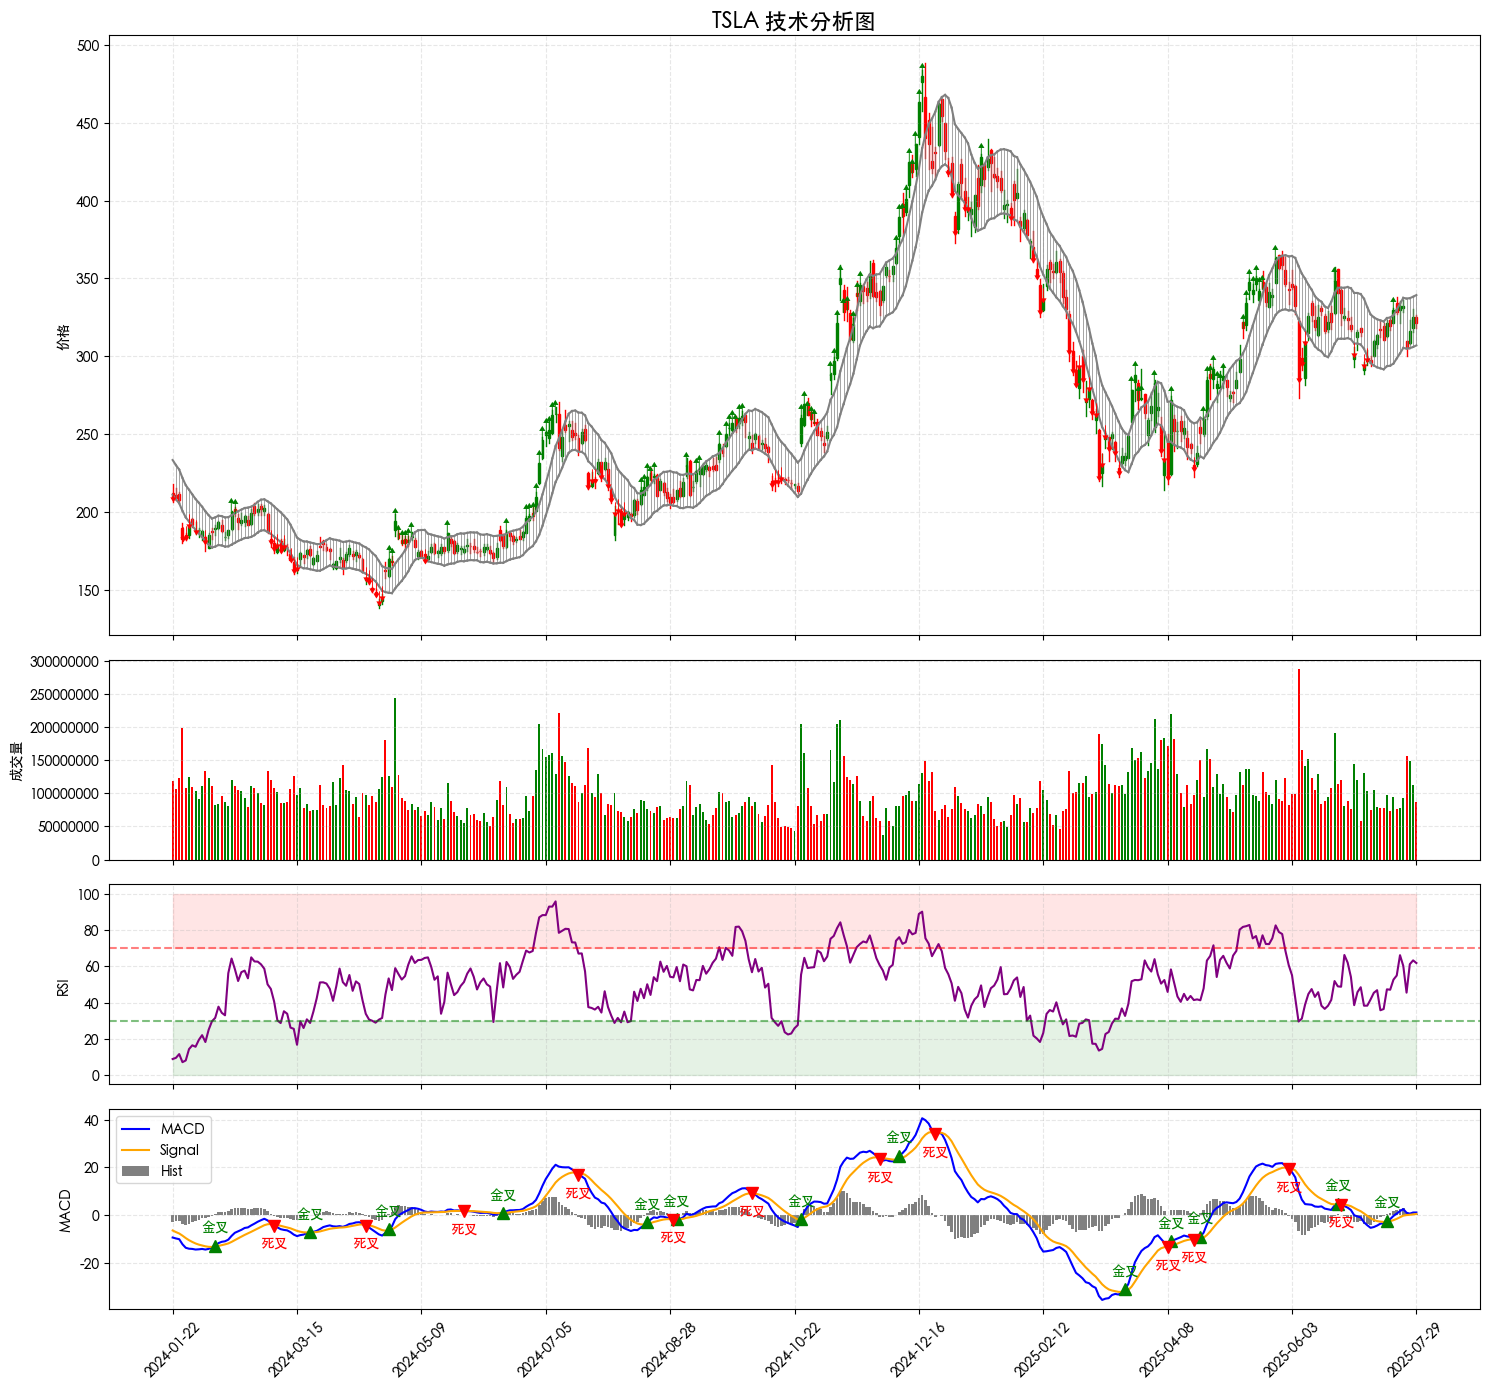

In [3]:
plot_stock_chart("TSLA")

